# Goal

The aim of this notebook is to know in deep the current situation of the Irish Real State Market and figure out what are the most promissing variables in order to infer the price.

# Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import pylab
from scipy.stats import kstest
import scipy.stats as stats
from scipy.stats import normaltest

import ppscore as pps
import random
from sklearn.tree import DecisionTreeRegressor



from daftpy.daftfeanalysis import (missing_values, frequencies, pct_method, 
                                   iqr_method, std_method, outlier_bool, drop_outliers, 
                                  print_limits, common_ix, drop_all_outliers,
                                  check_transformations, tchebycheff, drop_outliers_ix, 
                                  outplots)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
import warnings

def fxn():
    warnings.warn("user", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

# Load Data

In [4]:
sale = pd.read_csv('data_available/sale_post_geosp_fe.csv', sep=',', parse_dates=['entered_renewed', 'scraping_date'])
sale.shape

(7661, 24)

In [5]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   daft_id          7661 non-null   int64         
 1   url              7661 non-null   object        
 2   name             7661 non-null   object        
 3   price            7661 non-null   float64       
 4   sale_type        7661 non-null   object        
 5   floor_area       7661 non-null   int64         
 6   psr              7645 non-null   float64       
 7   ber              7466 non-null   object        
 8   entered_renewed  7661 non-null   datetime64[ns]
 9   views            7661 non-null   float64       
 10  type_house       7174 non-null   object        
 11  type             7661 non-null   object        
 12  scraping_date    7661 non-null   datetime64[ns]
 13  description      7660 non-null   object        
 14  latitude         7661 non-null   float64

Our target or variable response is `price`, whilst the other ones are predictors - variables that we can use to infer the price. Below you can see two tables with each variable, its meaning and a brief explanation about whether we intuitively consider it is an important predictor or not.

## Data Scraped From Daft.ie

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|price|House market price|High|It is the target|180000.0|
|daft_id|Ad's id|In-between|It could help us to identify a particular house if we need to|16878701|
|url|Ad's url|In-between|We can visit the ad if we need to|[https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666](https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666)|
|name|Ad's name|Low|Its sctructure is too much heterogeneous and we have coordinates|5 The Willows, Rivercourt, Drogheda, Co. Louth|
|sale_type||Low|Almost all values are the same|For Sale by Private Treaty|
|floor_area|House's floor area|High|High potencial as a predictor|106|
|psr|Advertiser's identifier|Low|It is not an important attribute of the house|2239.0|
|ber|House's energetic efficiency|In-between|No sabe no contesta|B3|
|entered_renewed|Date of entry or renewal of the ad|Low|If an ad has been published for a long time or not is impossible to know because it can have been renewed|2021-11-24 00:00:00|
|views|Number of visits to the ad|In-between|No sabe no contesta|1381.0|
|type_house|Apartment or house|High|It looks like an important attribute|apartment|
|type|Buy or rent|Low|We are analyzing houses for sale, al values are the same|buy|
|scraping_date|Date when ads were scraped|Low|All values are the same|2021-11-25 00:00:00|
|description|Ad's description|In-between||...|
|latitude|House's latitude|High|Provides information about location|53.715574|
|longitude|House's longitude|High|Provides information about location|-6.371515|
|bedroom|Number of bedrooms|High|It looks like an important attribute of a house|2|
|bathroom|Number of bathrooms|High|It looks like an important attribute of a house|2|
|plus_info|More info in a word|Low|I don't know why but it doesn't look like something important|Detached|

## Data From Feature Engineering Methods

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|postcode|It is the eircode||||
|state_district||Low|||
|city_district||Low|||
|place |Town or city|High|||
|code|Routing key|In-between|I think it would be the same effect than the variable 'place'||

# The Ireland's Real Estate Market

## Introduction

Agnadir algo de historia, como se distribuye y un par de mpaas.

## Current Situation of the Ireland's Real Estate Market

The information and graphs here try to help us to know a little bit the Irish Real Estate Market so we can focus in that areas we think are interesting in our search of potential investment opportunities.

The next schema show this chapter's structure.

!!!!!!!!!!!!!!!!!!!!schema

### Ireland's Real Estate Market

#### Advertisements per city

To figure out the number of advertisements per city we need to aggregate those ads with different postal districts from Dublin as they are separed.

In [6]:
# To show some postal districts
sale[['place']].dropna()[sale.place.dropna().str.contains('Dublin')].sample(3)

,place
139,Dublin 18
2647,Dublin 18
4133,Dublin 24


Something similar happens to Cork city butit has sides instead postal districts.

In [7]:
# To show both side names
pd.DataFrame(sale.place.dropna()[sale.place.dropna().str.contains('Cork')].value_counts()).rename(columns={'place':'freq_abs'})

,freq_abs
Cork city southside,275
Cork city northside,118


So let's build another column changing all those values by `Dublin` or `Cork`. After doing that, we can work with this new column or the another one depending our preferences.

In [8]:
# New column from `place` called `cities`
sale['cities'] = sale.place.copy()

# Index from ads to change
ix_to_change_dublin = sale.cities.dropna()[sale.cities.dropna().str.contains('Dublin')].index
ix_to_change_cork = sale.cities.dropna()[sale.cities.dropna().str.contains('Cork')].index

# Change them
sale.loc[ix_to_change_dublin, 'cities'] = 'Dublin'
sale.loc[ix_to_change_cork, 'cities'] = 'Cork'

To figure out the number of ads per city we are going to use the relative frequencies as we only have a sample of the population - the full market.

In [9]:
# Frequency table
freq = frequencies(df=sale, variable='cities')
freq.head()

,freq_abs,freq_rel
Dublin,1829,0.24
Cork,393,0.05
Galway,198,0.03
Limerick,178,0.02
Dun Laoghaire,141,0.02


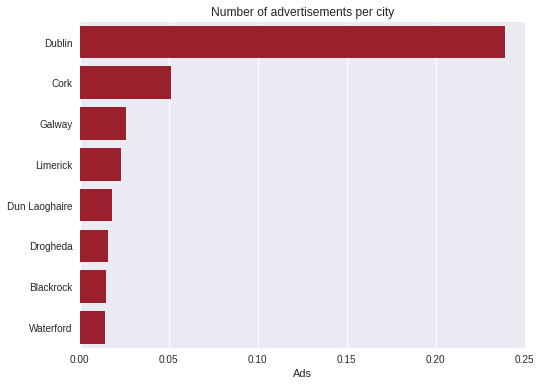

In [10]:
# Filter by cities whose frequency is greater than or equal to 50
freq_50 = freq[freq.freq_abs >= 100].copy()

fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=freq_50.freq_rel, y=freq_50.index, color='#b00b1e')

ax.set_title('Number of advertisements per city')
ax.set_xlabel('Ads')

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
#ax.set_yticks([]) 
ax.tick_params(bottom=False, left=False)  

As we can see Dublin and Cork are the cities with more ads. That is not surprising as they are the bigger ones. We will focus on them later.

#### Mean price per city

In [11]:
# Create new column for square meter prices
sale['m2_price'] = sale.price / sale.floor_area

In [12]:
# Mean price by `cities` sorted in descending order
# and filter by cities with more than 100 ads
mean_price_per_city = pd.pivot_table(data=sale, 
                                        index='cities', 
                                        values=['price', 'm2_price'], 
                                        aggfunc='mean')\
                        .sort_values(by='m2_price', ascending=False)\
                        .loc[freq[freq.freq_abs > 100].index]

# Cities with more than 100 ads
mean_price_per_city

,m2_price,price
Dublin,5118.62,595192.53
Cork,3068.37,355484.61
Galway,3008.69,365257.58
Limerick,2509.39,314817.42
Dun Laoghaire,7046.50,1523296.10
Drogheda,2497.31,299887.08
Blackrock,6260.81,874034.21
Waterford,2222.42,332217.59


Let's plot both mean prices.

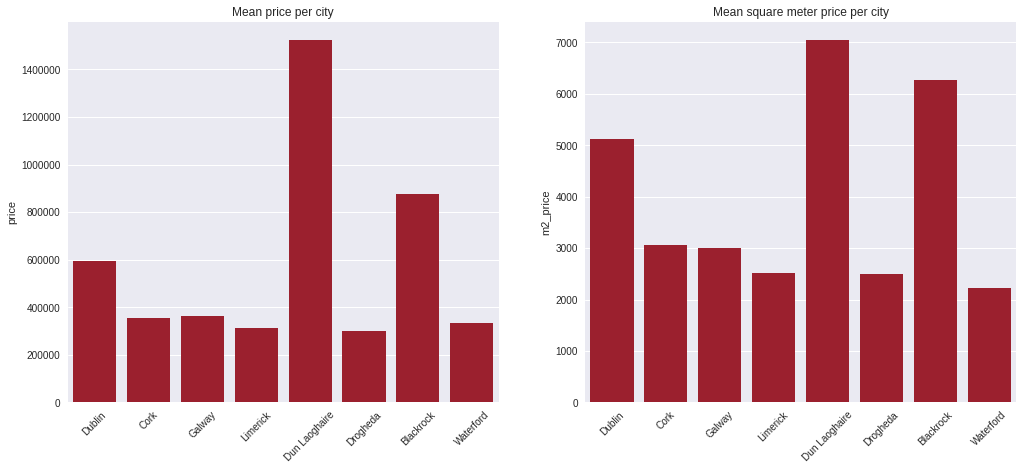

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs = sns.barplot(x=mean_price_per_city.price.index, 
                  y=mean_price_per_city.price, 
                  ax=axs[0], color='#b00b1e')
axs.set_title('Mean price per city')
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.price.index, 
                    rotation=45)

for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);


axs = sns.barplot(x=mean_price_per_city.m2_price.index, 
                  y=mean_price_per_city.m2_price, 
                  color='#b00b1e') 
axs.set_title('Mean square meter price per city')
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.m2_price.index, 
                    rotation=45)
for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);

Teniendo en cuanta ambos graficos podemos observar que que los lugares con mayores precios son Dublin, Dun Laoghaire y Blackrock. Sin embargo, tanto Dun Laoghaire como Blackrock pertenecen a Dublin. Se ha decidido estudiarlos por separado.

- Blackrock tiene un `m2_price` % inferior que Dun Laoghaire pero un `price` % menor, lo que nos indica que las casas en Blackrock son mas pequegnas que en Dun Laoghaire. Algo similar ocurre entre Dun Laoghaire y Dublin. 
- Cork y Galway, segunda y tercera ciudad por numero de habitantes, tienen precios muy similares.

#### Mean price per city by type_house

In [14]:
# Mean price by `cities` and `type_house`
# and filter by cities with more than 100 ads
mean_price_per_city_by_type_house = pd.pivot_table(data=sale, 
                                                   index=['cities', 'type_house'], 
                                                   values=['price', 'm2_price'], 
                                                   aggfunc='mean')\
                                      .sort_values(by='price', 
                                                   ascending=False)\
                                      .loc[freq[freq.freq_abs > 100].index]\
                                      .unstack()

mean_price_per_city_by_type_house

m2_price             price           
type_house    apartment   house apartment      house
cities                                              
Dublin          5210.59 5089.07 384142.56  702465.50
Cork            3449.26 3009.92 241361.70  374237.88
Galway          3373.77 2859.43 238068.18  403791.67
Limerick        2562.78 2517.95 172586.21  346974.82
Dun Laoghaire   6481.73 7157.72 583698.15 1815234.91
Drogheda        2356.28 2509.32 171702.94  325807.28
Blackrock       6084.17 6360.51 508460.26 1079928.87
Waterford       1970.78 2279.28 133947.37  373687.50

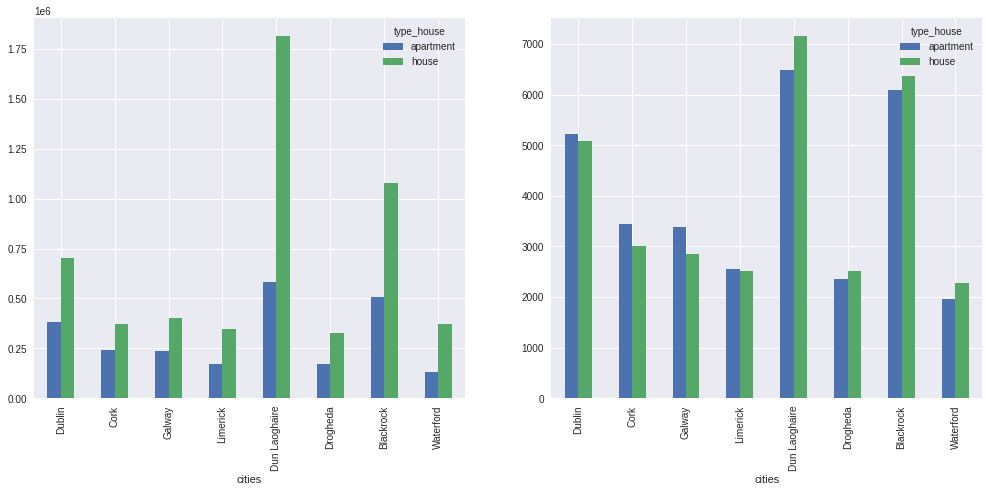

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

mean_price_per_city_by_type_house.price.plot(kind='bar', 
                                                 stacked=False, 
                                                 ax=axs[0])

mean_price_per_city_by_type_house.m2_price.plot(kind='bar', 
                                                stacked=False, 
                                                ax=axs[1]);

- `m2_price` es similar entre apartmets y houses en Dublin, Dun Laoghaire y Blackrock. Sin embargo los precios de las houses son mucho mas caras en los tres sitios, lo que nos indica que su tamagno es superior. 
- En Cork, asi como en Dublin, el `m2_price` de los apartments es un poco superior pero las casas son mas caras, lo que significa que se repite el mismo patron. 

### Dublin's Real Estate Market

We will need postal district's data if we want to dig a little into Dublin's Real Estate Market.

#### House Mean Price Per Postal District

In [16]:
# Filter to take Dublin related information
sale_dublin = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Dublin'))
                                                | (sale.place == 'Blackrock')
                                                | (sale.place == 'Dun Laoghaire')]
sale_dublin.shape

(2084, 26)

In [17]:
# Mean price by `place`
mean_price_dublin_by_postal_districts = pd.pivot_table(data=sale_dublin, 
                                                       index='place', 
                                                       values=['price', 'm2_price'], 
                                                       aggfunc='mean')\
                                          .sort_values(by='price', 
                                                       ascending=False)

mean_price_dublin_by_postal_districts.head(5)

,m2_price,price
place,,
Dun Laoghaire,7046.50,1523296.10
Dublin 6,6859.80,1174651.58
Dublin 4,7388.06,1016210.84
Blackrock,6260.81,874034.21
Dublin 2,6503.13,826590.91


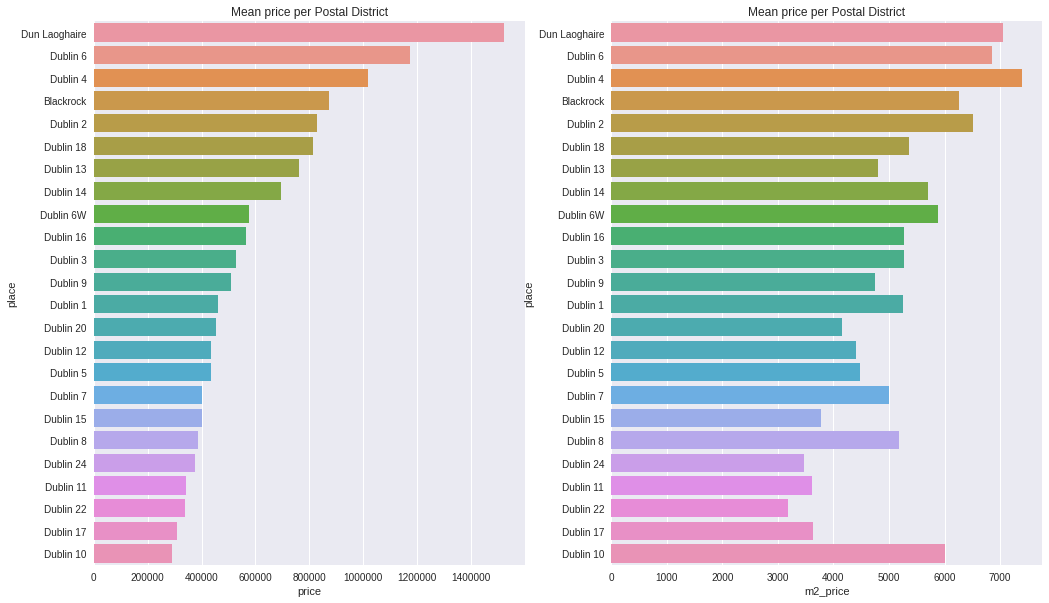

In [18]:
data = mean_price_dublin_by_postal_districts

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

axs = sns.barplot(x=data.price, y=data.index, data=data, ax=axs[0])
axs.set_title('Mean price per Postal District')
axs.ticklabel_format(style='plain', axis='x');

axs = sns.barplot(x=data.m2_price, y=data.index, data=data)  #, ax=axs[1]
axs.set_title('Mean price per Postal District')
axs.ticklabel_format(style='plain', axis='x');

#### House Mean Price Per Postal District per type_house

In [19]:
# Mean price by `place` and `type_house`
mean_price_dublin_by_postal_district_and_type_house = pd.pivot_table(data=sale_dublin, 
                                                                     index=['place', 'type_house'], 
                                                                     values=['price', 'm2_price'], 
                                                                     aggfunc='mean')\
                                                        .sort_values(by='price', 
                                                                     ascending=False)\
                                                        .unstack()

mean_price_dublin_by_postal_district_and_type_house.head()

m2_price             price           
type_house apartment   house apartment      house
place                                            
Blackrock    6084.17 6360.51 508460.26 1079928.87
Dublin 1     5550.61 4782.34 451165.91  483447.96
Dublin 10    3627.45 6355.89 185000.00  294000.00
Dublin 11    3432.50 3734.97 212661.11  382877.03
Dublin 12    3922.84 4384.43 273368.75  445923.53

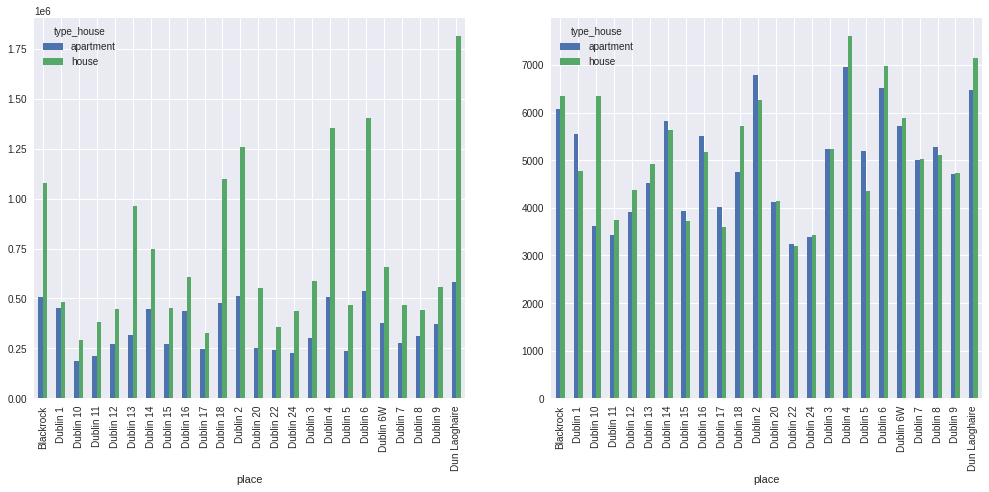

In [20]:
data = mean_price_dublin_by_postal_district_and_type_house

fig, axs = plt.subplots(1, 2, figsize=(17, 7))

data.plot(y='price', kind='bar', stacked=False, ax=axs[0]);
data.plot(y='m2_price', kind='bar', stacked=False, ax=axs[1]);

#### Floor Area per postal district and type_house

In [21]:
# Mean floor area by `place` and `type_house`
mean_floor_area_dublin_by_postal_district = pd.pivot_table(data=sale_dublin, 
                                                           index=['place', 'type_house'], 
                                                           values='floor_area', 
                                                           aggfunc='mean')\
                                              .sort_values(by='floor_area', 
                                                           ascending=False)\
                                              .unstack()

mean_floor_area_dublin_by_postal_district.head()

floor_area       
type_house  apartment  house
place                       
Blackrock       86.23 170.61
Dublin 1        83.35 101.51
Dublin 10       51.00  86.27
Dublin 11       62.78 128.05
Dublin 12       72.12 103.66

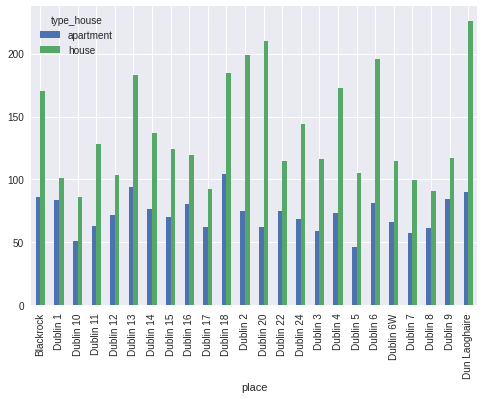

In [22]:
#fig= plt.figure(figsize=(8,6))
mean_floor_area_dublin_by_postal_district.plot(y='floor_area', kind='bar', stacked=False);

#### Number of Advertisements per PD and type_house

### Cork's Real Estate Market

#### Mean price per side

In [23]:
# Filter to take Cork related information
sale_cork = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Cork'))]
sale_cork.shape

(393, 26)

In [24]:
# Mean price by `place`
mean_price_cork_by_side = pd.pivot_table(data=sale_cork, 
                                         index='place', 
                                         values=['price', 'm2_price'], 
                                         aggfunc='mean')\
                            .sort_values(by='price', 
                                         ascending=False)

mean_price_cork_by_side

,m2_price,price
place,,
Cork city southside,3213.33,371049.09
Cork city northside,2730.56,319211.44


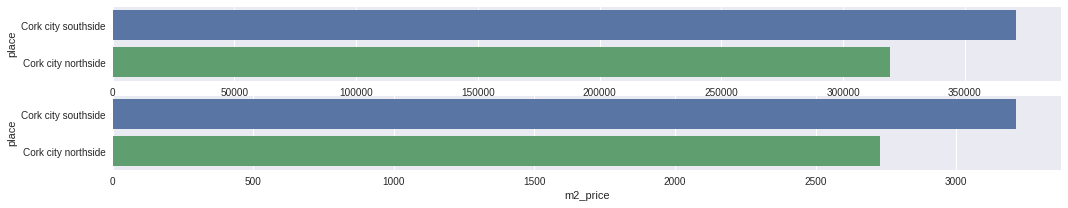

In [25]:
data = mean_price_cork_by_side

fig, axs = plt.subplots(2, 1, figsize=(17, 3))

axs = sns.barplot(x=data.price, y=data.index, data=data, ax=axs[0])
#axs.set_title('Mean price per Postal District');
axs.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(mean_price.index, rotation=45);

axs = sns.barplot(x=data.m2_price, y=data.index, data=data)
#axs.set_title('Mean price per Postal District');
axs.ticklabel_format(style='plain', axis='x');

#### Mean price per side and type_house

In [26]:
# Mean price by `place` and `type_house`
mean_price_cork_by_side_and_type_house = pd.pivot_table(data=sale_cork, 
                                                        index=['place', 'type_house'], 
                                                        values=['price', 'm2_price'], 
                                                        aggfunc='mean')\
                                            .sort_values(by='m2_price', 
                                                         ascending=False)\
                                            #.unstack()

mean_price_cork_by_side_and_type_house

m2_price     price
place               type_house                    
Cork city southside apartment    3640.19 258216.22
                    house        3148.82 391041.85
Cork city northside apartment    2742.81 179000.00
                    house        2703.80 337203.88

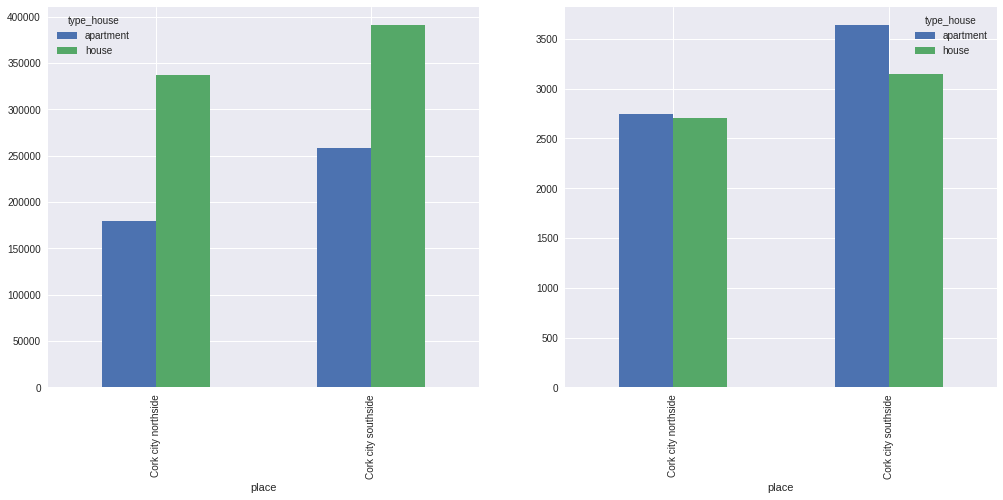

In [27]:
data = mean_price_cork_by_side_and_type_house
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

mean_price_cork_by_side_and_type_house.unstack().plot(y='price', kind='bar', stacked=False, ax=axs[0]);
mean_price_cork_by_side_and_type_house.unstack().plot(y='m2_price', kind='bar', stacked=False, ax=axs[1]);

#### Mean floor area per postal district and type_house

In [28]:
# Mean floor area by `place` and `type_house`
mean_floor_area_cork_by_side = pd.pivot_table(data=sale_cork, 
                                              index=['place', 'type_house'], 
                                              values='floor_area', aggfunc='mean')\
                                 .sort_values(by='floor_area', 
                                              ascending=False)

mean_floor_area_cork_by_side

floor_area
place               type_house            
Cork city northside house           173.44
Cork city southside house           133.51
                    apartment        74.51
Cork city northside apartment        67.00

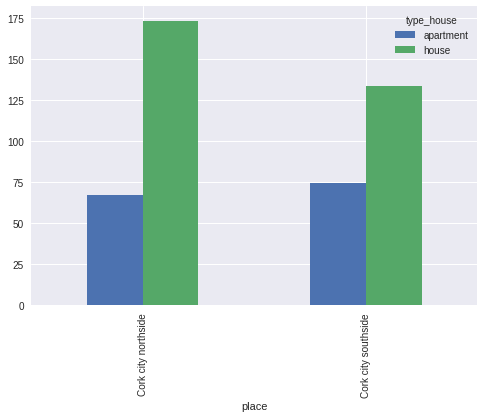

In [29]:
mean_floor_area_cork_by_side.unstack().plot(y='floor_area', kind='bar', stacked=False);

DROP M2_PRICE

#### Number of Advertisements per side and type_house

# Distributions

## Numeric Variables

The graphs below show the distribution of each numeric variable. We can see that most of them are heavy skewed to the right and have a lot of outliers. It is normal to happend when the variable is capped at zero on the lower size. Also, a house do not usually have 10000 square meters and 40 bathrooms so it is possible to have some commercial properties ads in the data set. As we are working on a regression problem we should remove those outliers as they can distort the results and predictive power of the models. 

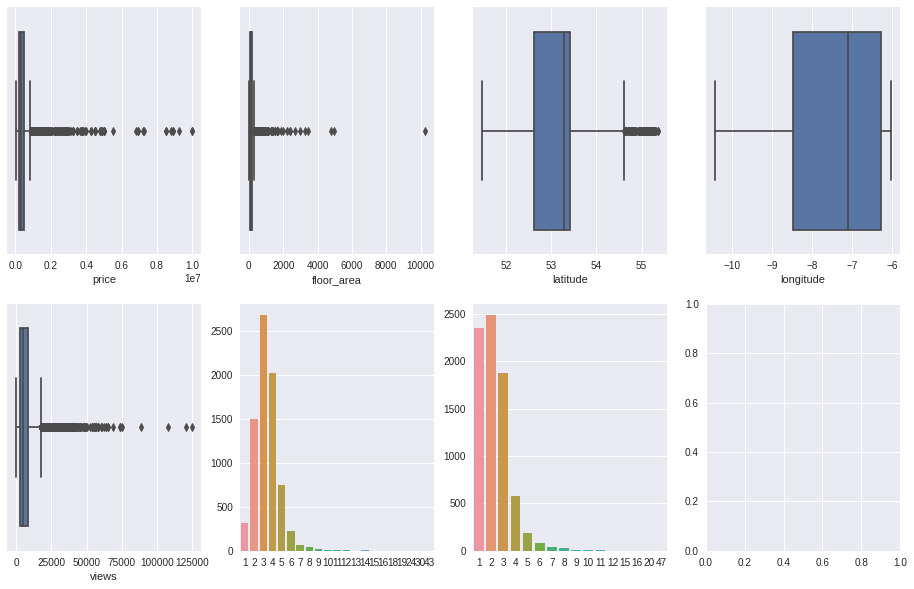

In [30]:
fig, axs = plt.subplots(2, 4, figsize=(16, 10))

features = ['price', 'floor_area', 'latitude', 'longitude', 'views', 'bedroom', 'bathroom']

i = 0
row = 0
column = 0

for feature in features:
    if i == 4:
        row = 1
        column = 0
    
    if (feature != 'bedroom') and (feature != 'bathroom'):
        sns.boxplot(data=sale[feature], x=sale[feature], 
                    ax=axs[row, column])
    else:
        sns.barplot(x=sale[feature].value_counts().index, 
                    y=sale[feature].value_counts().values, 
                    ax=axs[row, column]);
    i += 1
    column += 1

Before dropping any outlier let's calculate the skewness and Tchebycheff bounds in order to be able to check the result of the variable's transformation after dropping them. We are going to use k = 2 so there will be a 75% of probabilities that an ads is between both limits.

In [31]:
numeric_features = ['price', 'floor_area', 'views', 
                    'bedroom', 'bathroom', 'latitude', 
                    'longitude']

tchebycheff(df=sale, 
            num_features=numeric_features, 
            k=2)

k = 2 -> 75.0%


,skewness,lim_inf,lim_sup
price,8.03,-647768.94,1517692.33
floor_area,24.55,-246.86,543.48
views,4.11,-8030.83,22316.47
bedroom,5.19,0.36,6.43
bathroom,5.85,-0.61,5.22
latitude,-0.02,51.62,54.54
longitude,-0.44,-9.80,-5.06


### Outliers Detection and Elimination

We will consider a value as an outlier only when it is detecting for each one of the following methods.

**Percentile Based Method**
The percentile method cuts off a predefined percentage amount from the top and the bottom of a distribution (if both sides are desired). 

**Interquartile Range Method**
The interquartile range approach first calculates the interquartile range of the data and then this range is multiplied with 1.5. Any data that is then further away than any of the limits calculated is classified as an outlier.

Before drop any value let's see how many outliers are detected in each variable and what are the resulting bounds.

#### Detecting `price` Outliers

In [32]:
print_limits(sale, 'price')

Percentile based method: [79000.0, 2650000.0]
Interquartile range method: [-155000.0, 845000.0]


In [33]:
no_out_price, outliers_price = drop_outliers(sale, 'price', continuous=True)

Range before: [32000.0, 10000000.0]

Limits: [-155000.0, 2650000.0]
No outliers: 7587
Outliers: 74

Range after: [32000.0, 2650000.0]
Outliers dropped: 74


#### Detecting `floor_area` Outliers

In [34]:
print_limits(sale, 'floor_area')

Percentile based method: [40.0, 628.1999999999971]
Interquartile range method: [-43.0, 293.0]


In [35]:
no_out_farea, outliers_farea = drop_outliers(sale, 'floor_area', continuous=True)

Range before: [1, 10279]

Limits: [40.0, 628.1999999999971]
No outliers: 7513
Outliers: 148

Range after: [40, 625]
Outliers dropped: 148


#### Detecting `views` Outliers

In [36]:
print_limits(sale, 'views')

Percentile based method: [329.4000000000001, 37978.59999999989]
Interquartile range method: [-6010.5, 17481.5]


In [37]:
no_out_views, outliers_views = drop_outliers(sale, 'views', continuous=True)

Range before: [0.0, 125030.0]

Limits: [-6010.5, 37978.59999999989]
No outliers: 7584
Outliers: 77

Range after: [0.0, 37857.0]
Outliers dropped: 77


#### Detecting `bedroom` Outliers

In [38]:
print_limits(sale, 'bedroom')

Percentile based method: [1.0, 8.0]
Interquartile range method: [1.5, 5.5]


In [39]:
no_out_bedroom, outliers_bedroom = drop_outliers(sale, 'bedroom', continuous=True)

Range before: [1, 43]

Limits: [1.0, 8.0]
No outliers: 7608
Outliers: 53

Range after: [1, 8]
Outliers dropped: 53


#### Detecting `bathroom` Outliers

In [40]:
print_limits(sale, 'bathroom')

Percentile based method: [1.0, 7.0]
Interquartile range method: [-2.0, 6.0]


In [41]:
no_out_bathroom, outliers_bathroom = drop_outliers(sale, 'bathroom', continuous=True)

Range before: [1, 47]

Limits: [-2.0, 7.0]
No outliers: 7594
Outliers: 67

Range after: [1, 7]
Outliers dropped: 67


#### Dropping Outliers

Once we have detected the outliers we can use their index to drop them.

In [42]:
outliers_list = [
    outliers_price.index,
    outliers_farea.index,
    outliers_views.index,
    outliers_bedroom.index,
    outliers_bathroom.index,                 
                ]

sale_out = drop_outliers_ix(df=sale, index_list=outliers_list)

Outliers dropped: 317


And if we check the skewness and the Tchebycheff bounds we will see that skewness has reduced a lot and the bounds are closer to each other.

In [43]:
tchebycheff(df=sale_out, num_features=numeric_features, k=2)

k = 2 -> 75.0%


,skewness,lim_inf,lim_sup
price,3.10,-206768.68,982658.68
floor_area,1.91,-16.24,281.75
views,2.06,-4767.06,17825.83
bedroom,0.51,1.01,5.59
bathroom,1.00,-0.01,4.42
latitude,-0.02,51.63,54.54
longitude,-0.43,-9.79,-5.07


### Checking Outliers Elimination Results

Now let's dig a little deeper to check the results of those outliers elimination and how the distributions are afected by that and other transformation like Logarithmic or Coxbox transformations.

**The Cutoff Levels**

||Price|floor Area|Views|Bedroom|Bathroom|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**Minimum**|32000.00|1|0.00|1|1|
|**Cutoff Min**|32000.00|40|0.00|1|1|
|**Cutoff Max**|2650000.00|732|46044.00|8|7|
|**Maximun**|10000000.00|10279|125030.00|43|47|

After dropping outliers the cutoff levels appear much more reasonable.

We are going to plot every variable whit histograms (bar plots for discrete ones) and probability plots. The dangerous zone (red area) is where the outliers are, it has been colored to see more easily the effect of teh transformations.

#### Price Outliers Elimination Results

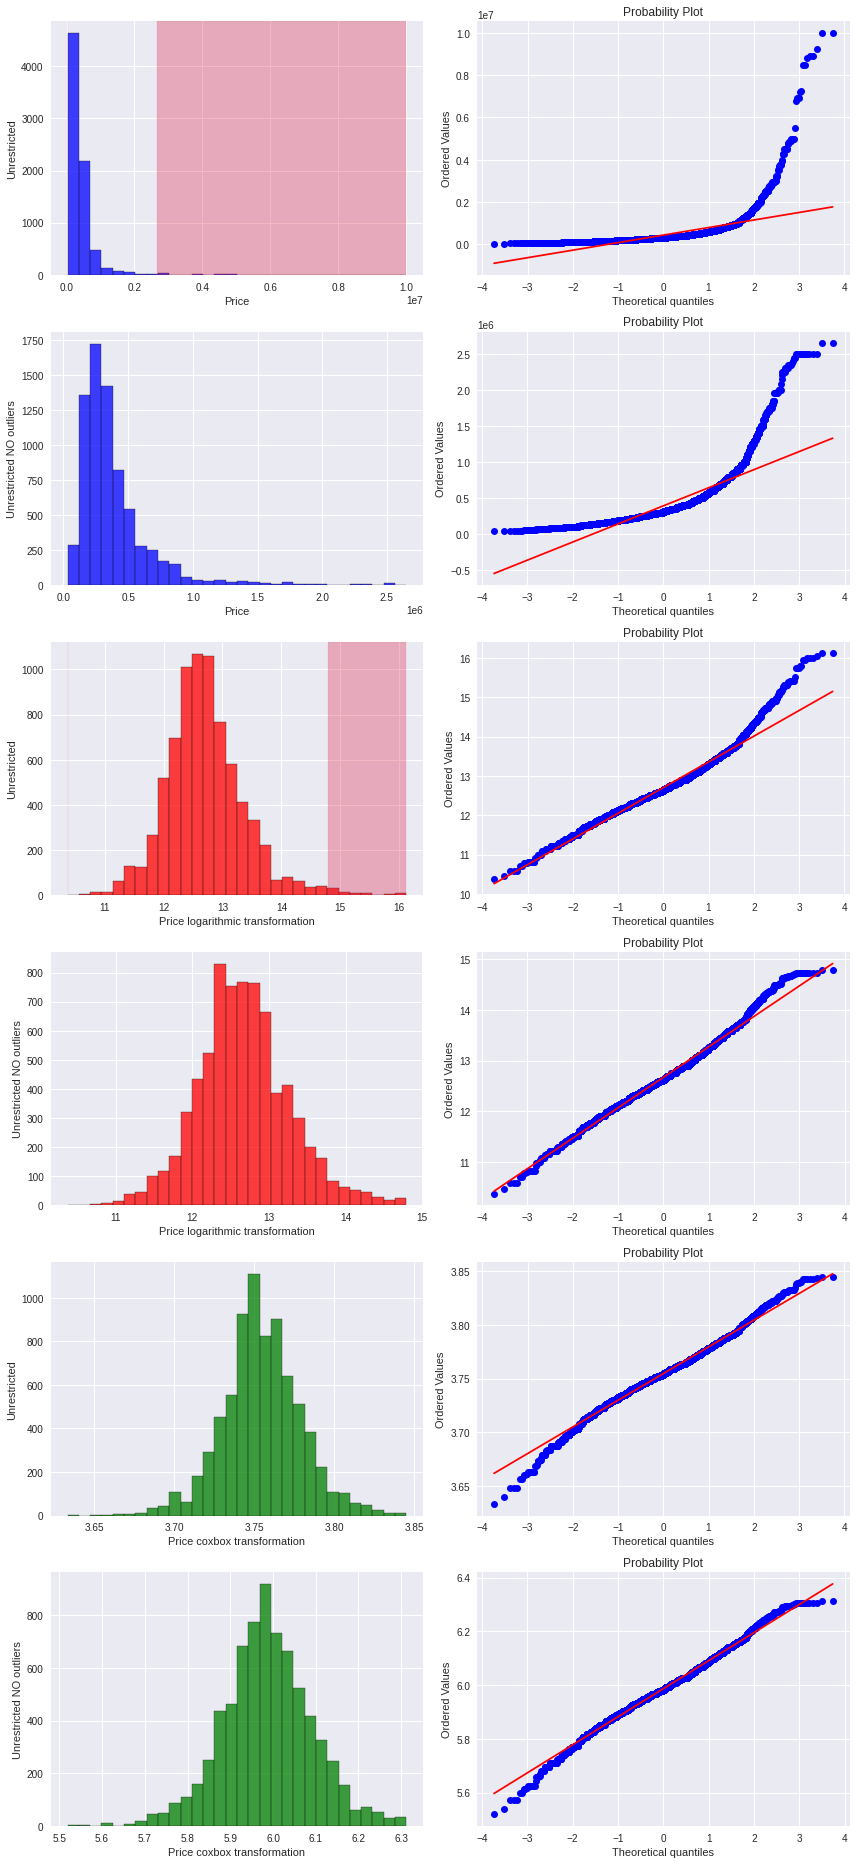

In [44]:
check_transformations('price', sale, sale_out)

#### Floor Area Outliers Elimination Results

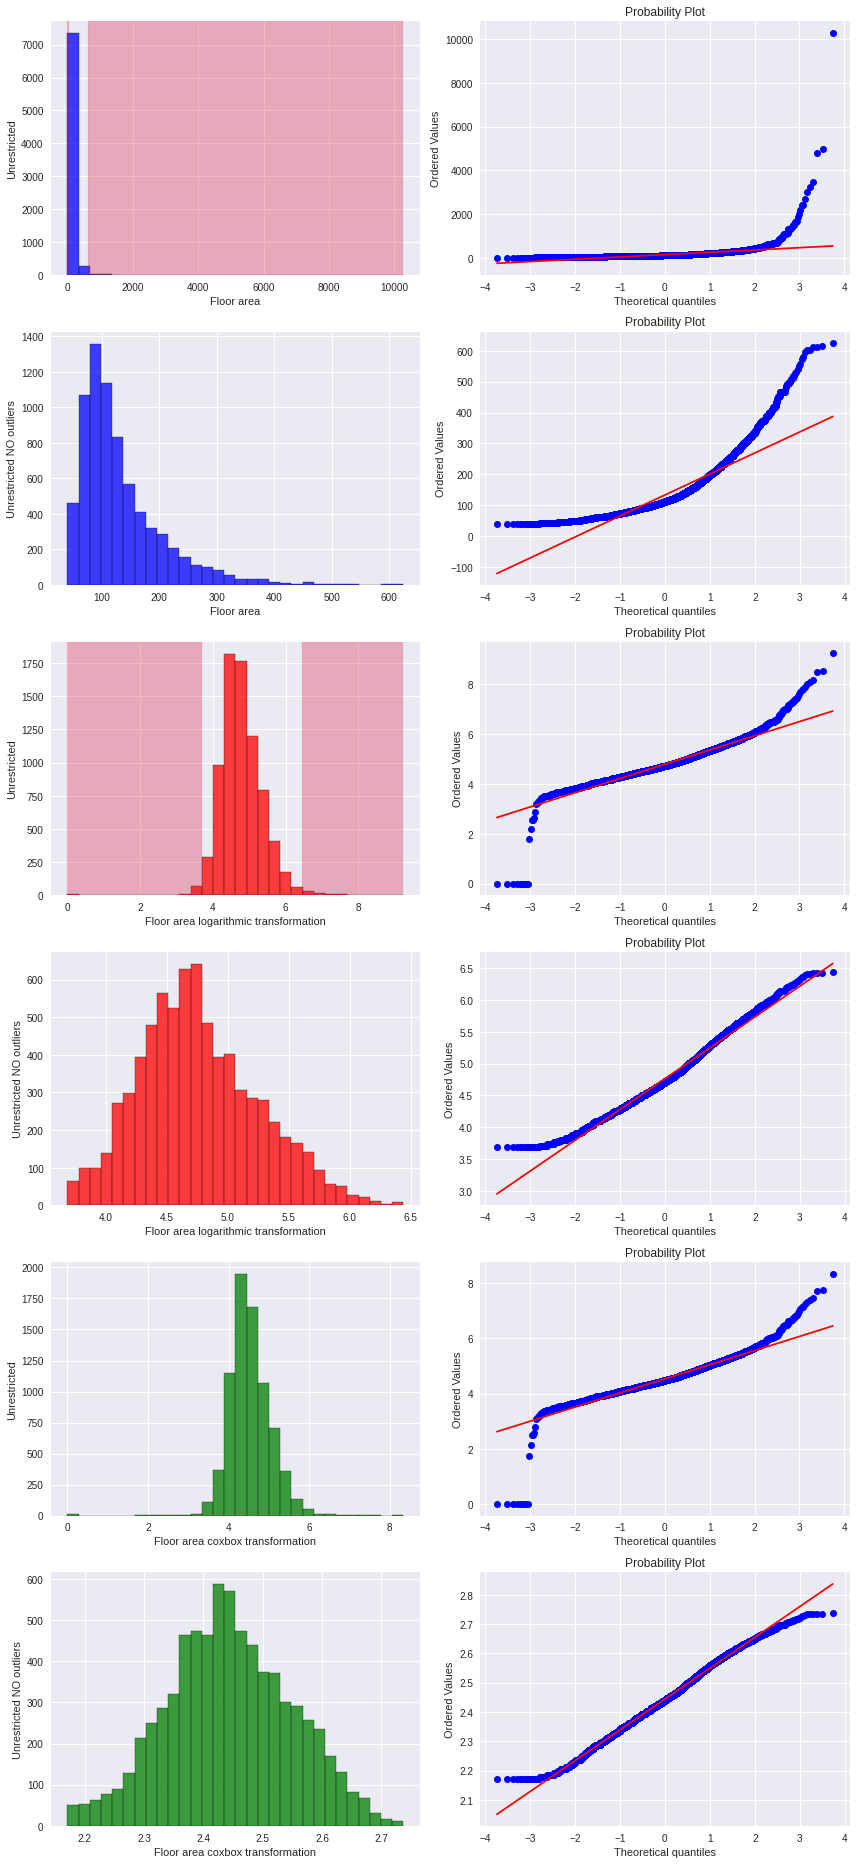

In [45]:
check_transformations('floor_area', sale, sale_out)

#### Views Outliers Elimination Results

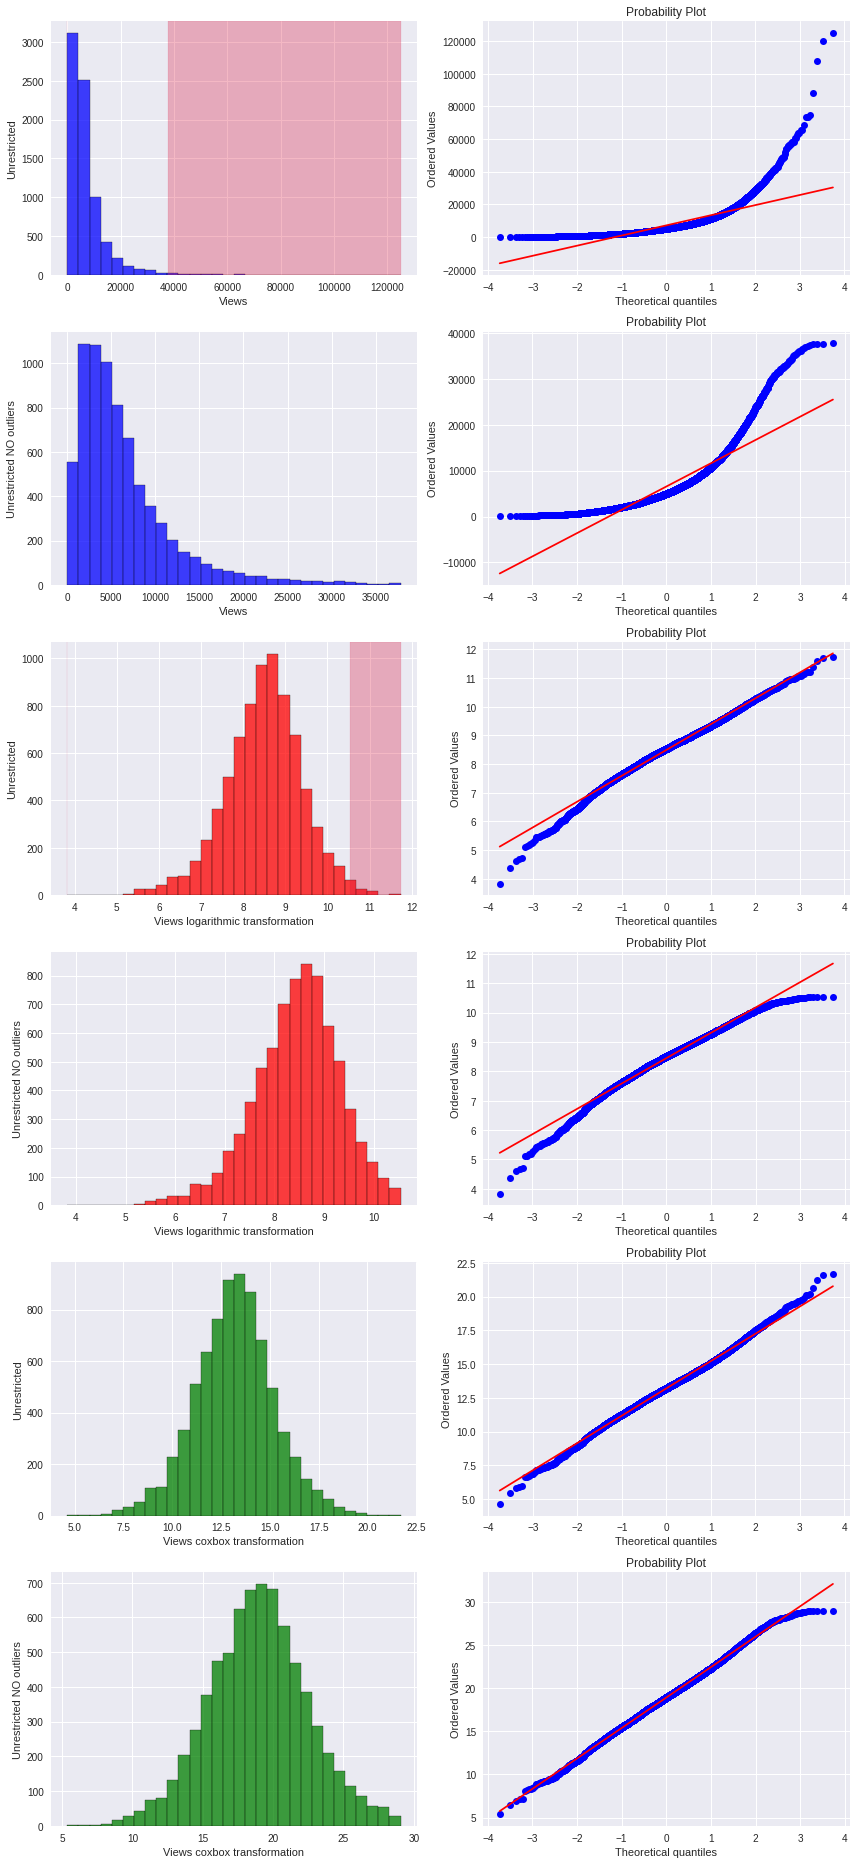

In [46]:
check_transformations('views', 
                      sale.loc[sale['views']!=0].copy(), 
                      sale_out.loc[sale_out['views']!=0].copy())

#### Bedroom Outliers Elimination Results

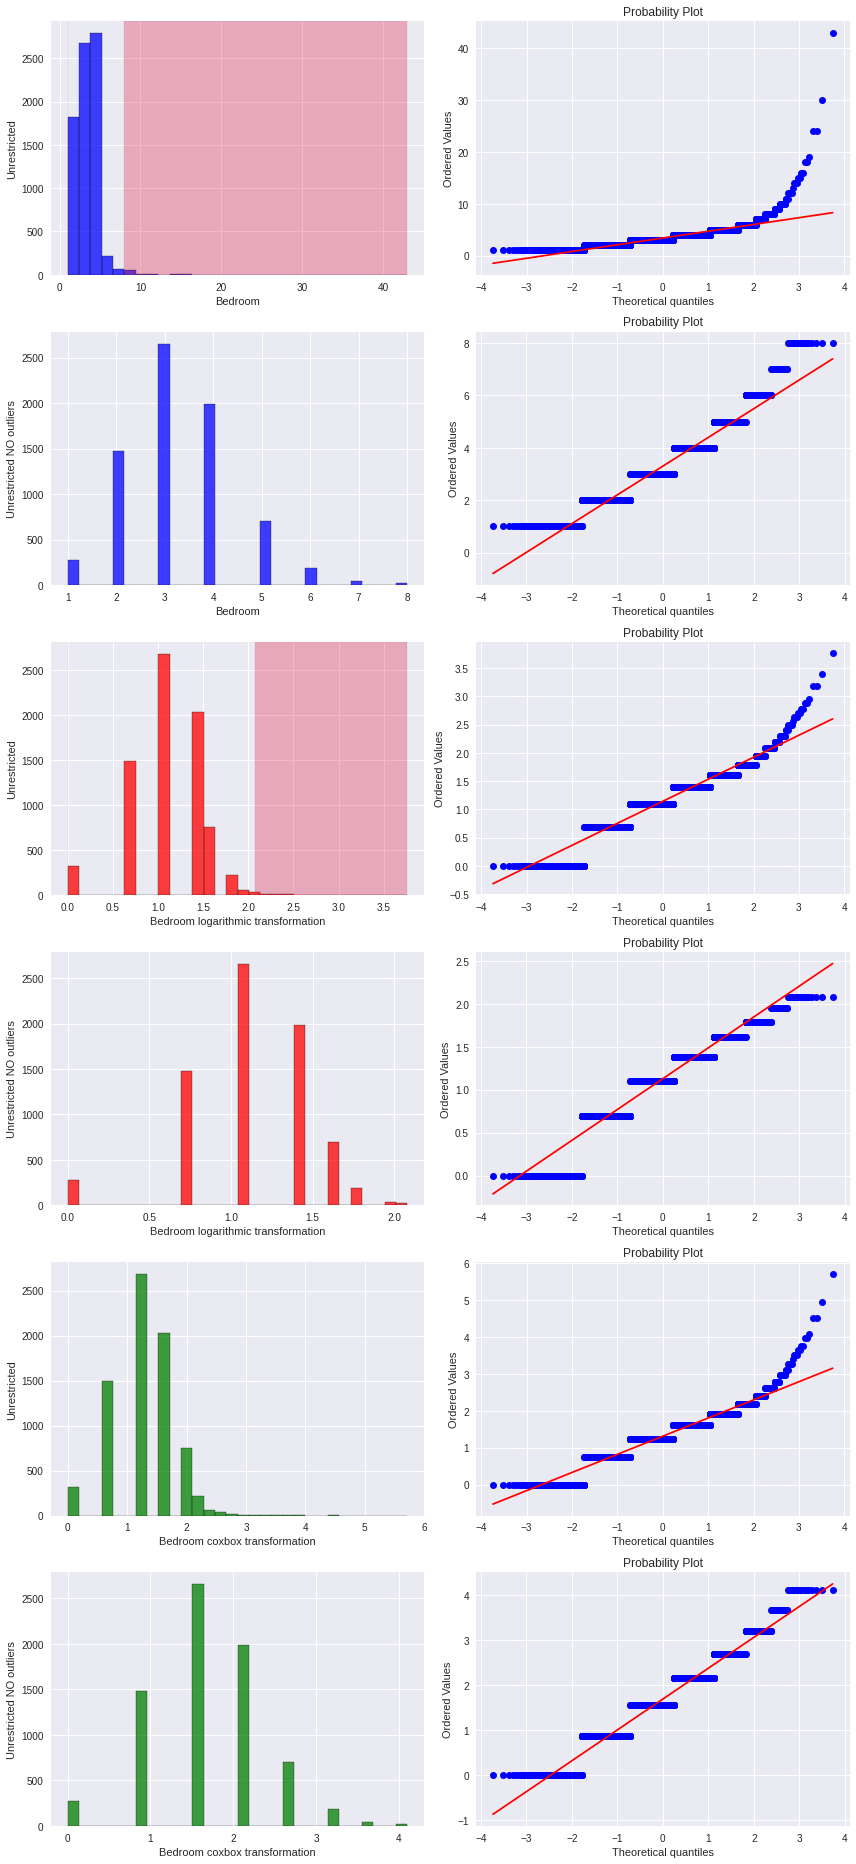

In [47]:
check_transformations('bedroom', sale, sale_out)

#### Bathroom Outliers Elimination Results

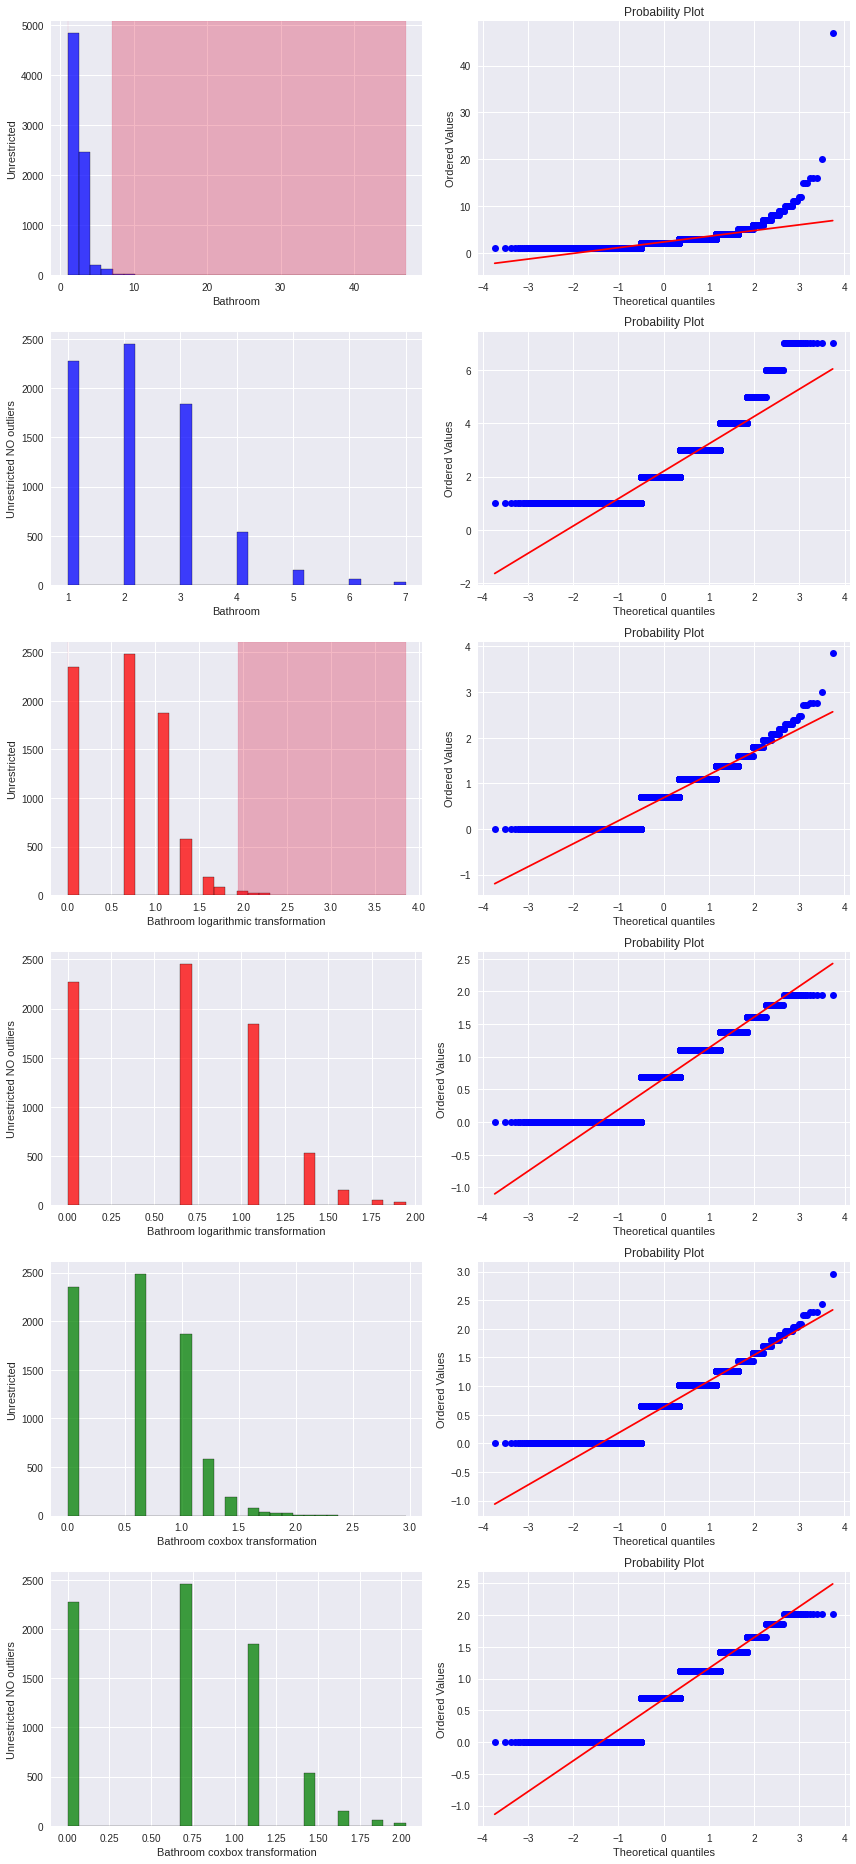

In [48]:
check_transformations('bathroom', sale, sale_out)

### Conclusions

As we have seen, the elimination of outliers and a few kind of transformations can help us to reduce the skewness and obtain something closer to a Gaussian distribution. We will do the Box Cox transformation before to feed the algorithms with the data.

## Categorical Variables

We will need to transform the categorical data before to show it to the algorithms so let's explore it and check what types of transformations can we make.

### Type House

In [49]:
sale_out.type_house.value_counts()

house        5767
apartment    1106
Name: type_house, dtype: int64

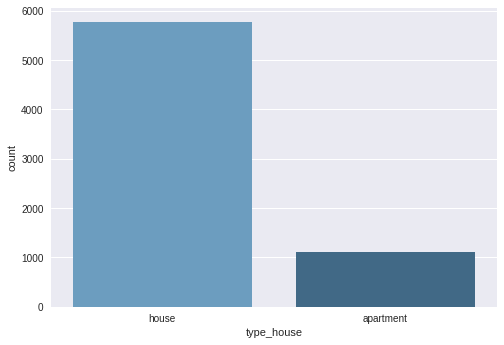

In [50]:
sns.countplot(data=sale_out, x='type_house', palette="Blues_d");

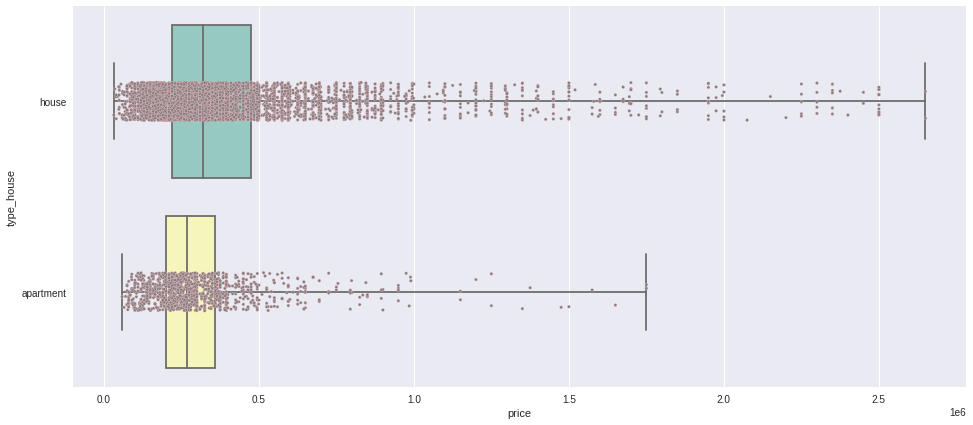

In [67]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = sns.boxplot(data=sale_out, x='price', y='type_house', orient='h', 
                 order=['house', 'apartment'],
                 whis=np.inf, palette="Set3")
ax = sns.stripplot(data=sale_out, x='price', y='type_house' ,orient='h', 
                   order=['house', 'apartment'],
                   color="gray", edgecolor="pink", linewidth=.3,  size=3)

### Ber

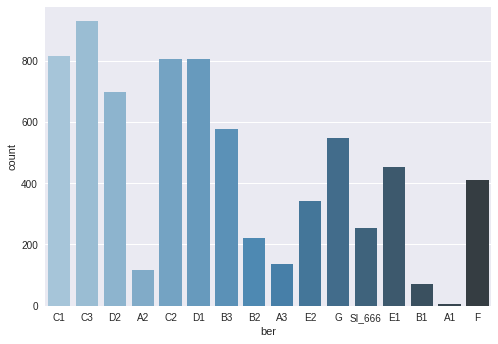

In [70]:
sns.countplot(data=sale_out, x='ber', palette="Blues_d");

In [51]:
sale_out.ber.value_counts()

C3        929
C1        814
C2        806
D1        806
D2        698
B3        578
G         547
E1        454
F         409
E2        343
SI_666    253
B2        220
A3        137
A2        117
B1         70
A1          6
Name: ber, dtype: int64

### Plus Info

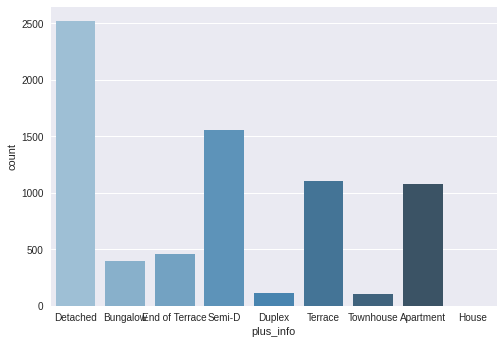

In [71]:
sns.countplot(data=sale_out, x='plus_info', palette="Blues_d");

In [52]:
sale.plus_info.value_counts()

Detached          2710
Semi-D            1580
Terrace           1145
Apartment         1117
End of Terrace     473
Bungalow           416
Duplex             111
Townhouse          107
House                2
Name: plus_info, dtype: int64

### Place

Ya hemos visto esta informacion en el otro apartado

In [73]:
sale_out.place.value_counts().sort_values(ascending=False).head()

Cork city southside    268
Galway                 191
Limerick               175
Dublin 4               144
Dublin 18              142
Name: place, dtype: int64

### Postcode and Code

In [54]:
#sale_out.postcode.value_counts()  tiene sentido meterla?

In [55]:
#sale_out.code.value_counts() #no seria lo mismo que place?

### State District

In [56]:
sale_out.state_district.value_counts()

Leinster    4000
Munster     1998
Connacht     962
Name: state_district, dtype: int64

### City_district

In [57]:
sale_out.city_district.value_counts().head()  

Ballincollig - Carrigaline    126
Clondalkin ED                  60
Stillorgan ED                  57
Blanchardstown ED              49
Glencullen ED                  46
Name: city_district, dtype: int64

# Relationships and Feature Selection

## Scatter Plots

We are going to use scatter plots in order to figure out relationships between variables. Scatter plots can help us visualizate linear relationships as well as nonlinear relationships. 

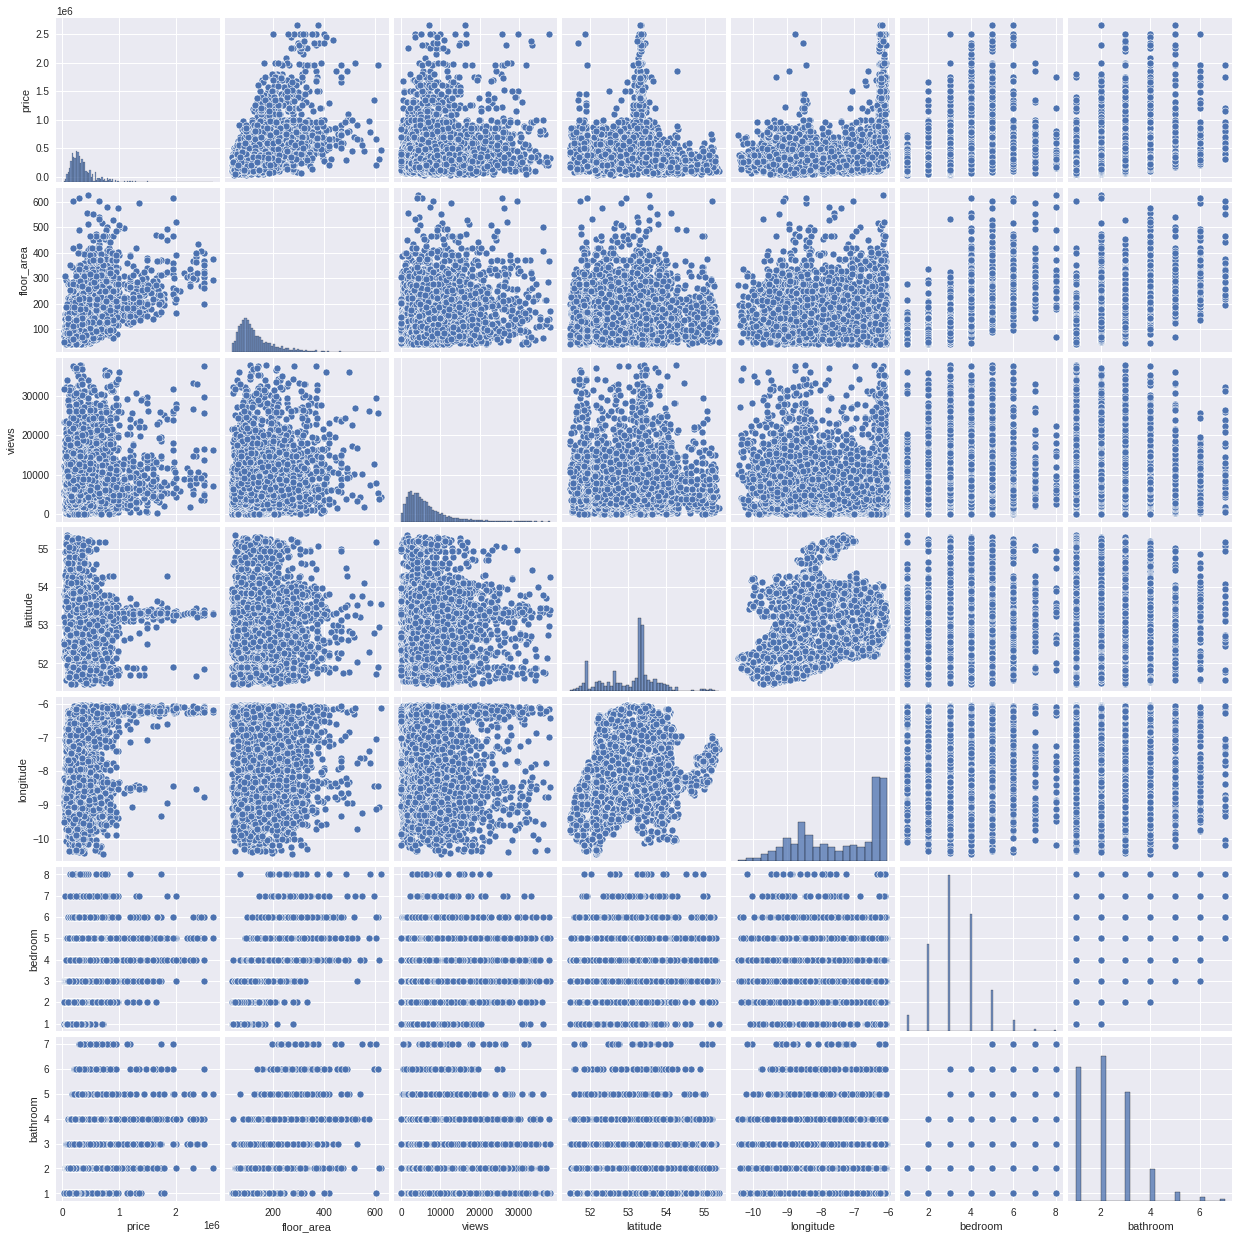

In [58]:
variables = ['price', 
             'floor_area', 
             'views', 
             'latitude', 
             'longitude', 
             'bedroom', 
             'bathroom',  
            # 'm2_price'
            ]

sns.pairplot(sale_out[variables]);

It is difficult to see any relationship in most cases but there are a few ones:
- It seems to be an increasing linear relationships between `price` and `floor_area`.
- `bedroom` and `bathroom` seem to have a mild relationships with `price` and maybe a little stronger one with `floor_area`.
- `latitude` and `longitude` both show two rare patterns where `price` increases around two differents coordinates values. Actually these patterns have a logic explanation. 
The longitude with higher prices matches with Dublin and the other one that stands out from the rest matches with Cork and Galway, as both have similar coordinates. 
Something similar happens in the latitude plot. Dublin and Galway have similar latitudes and Cork is in the south. 
We can see this if we look a map as the scatter plot between `latitude` and `longitude` and compare it with the other plots.

## Correlations

Now let's see what correlation coefficients have to say. We are going to plot a heatmap for the Pearson correlation coefficient and another one for the Spearman's one. But first let's remember them.

Pearson vs Spearman:

- The Pearson correlation coefficient is a statistic that measures the linear correlation between two variables. This statistic can evaluate only a linear relationship between two continuous variables (proportional change).
- The Spearman's rank correlation coefficient is a nonparametric measure of [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). This statistic can evaluate a [monotonic](https://es.wikipedia.org/wiki/Funci%C3%B3n_mon%C3%B3tona) relatinship between two variables - continuous or ordinal.

Differences:
- Pearson coefficient works with linear relationships whereas Spearman coefficient works with monotonic relationships as well.
- Pearson works with raw data values of the variable whereas Spearman works with rank-ordered variables.

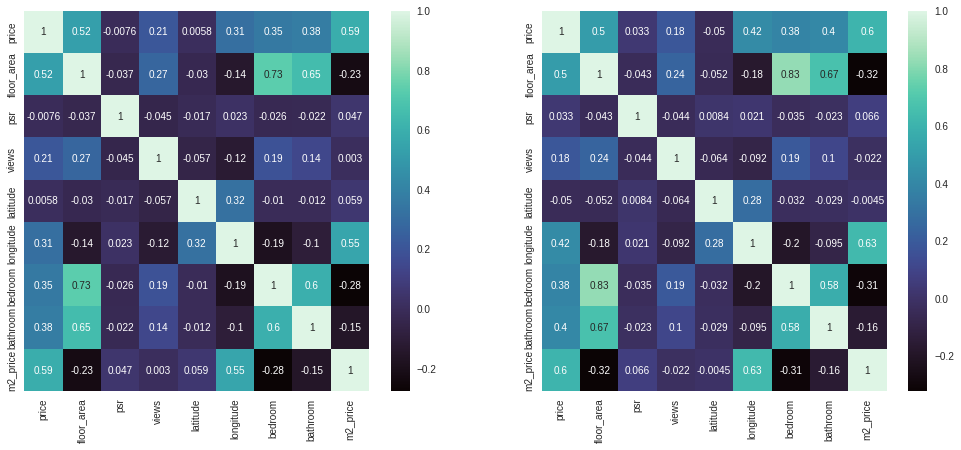

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='pearson'), 
            annot=True, cmap='mako', ax=axs[0])
sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='spearman'), 
            annot=True, cmap='mako', ax=axs[1]);

Conclusions:

- As we concluded from the scatter plots there is a linear relationships between `price` and `floor_area`. 
- `longitude`, `bedroom`, and `bathroom` show interesting relationships with the `price`. We can note how `bedroom` and `bathroom` are also correlated with `floor_area`, which makes sense.
- There are no strong decreasing relationships between variables.

I conclude that it would be good looking for more data in order to find more variables with predictive capabilities. But first let's plot a Predictive Power Score matrix to see if something interesting is slipping out of our hands.

## Predictive Power Score

Predictive Power Score is a kind of score that is asymmetric and data-type agnostic and helps in identifying linear and non-linear relationships between two variables. We can figure out how useful a variable would be in predicting the values of another one.

- PPS lies between 0 (no predictive power) and 1 (highest predictive power).
- PPS let us handle not only numerical variables (as correlation) but also other kinds of values namely categoric, nominal, etc.
- PPS can find out non-linear relationships among different variables whic cannot be obtained from correlation.
- Correlation matrix is symmetrical, which can give a misleading interpretation that the correlation of column A to B is and B to A is the same. PPS is asymmetric, which means that if column A can predict column B values, it does not mean that column B can also predict column A.

More information about PPS:

- [ppscore - a Python implementation of the Predictive Power Score (PPS)](https://github.com/8080labs/ppscore)
- [Introducing the Predictive Power Score (PPS)](https://docs.bamboolib.8080labs.com/documentation/reference/predictors#introducing-the-predictive-power-score-pps)
- [RIP correlation. Introducing the Predictive Power Score](https://medium.com/towards-data-science/rip-correlation-introducing-the-predictive-power-score-3d90808b9598)
- [What is Predictive Power Score (PPS) – Is it better than Correlation ?](https://machinelearningknowledge.ai/predictive-power-score-vs-correlation-with-python-implementation/)

**Regression**

In case of an regression, the ppscore uses the mean absolute error (MAE) as the underlying evaluation metric (MAE_model). The best possible score of the MAE is 0 and higher is worse. As a baseline score, we calculate the MAE of a naive model (MAE_naive) that always predicts the median of the target column. The PPS is the result of the following normalization (and never smaller than 0):

> PPS = 1 - (MAE_model / MAE_naive)

In [84]:
variables = ['price', 'sale_type', 'floor_area', 'psr', 
             'ber', 'views', 'type_house',
             'latitude', 'longitude', 'bedroom',
             'bathroom', 'plus_info', 'postcode', 
             'state_district', 'city_district',
             'place', 'code', 'cities']

# You can see the resulted DataFrame with the following line of code
pps.predictors(sale_out[variables], 'price', output='df', sorted=True).head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,city_district,price,0.13,regression,True,mean absolute error,180880.01,157565.21,DecisionTreeRegressor()
1,place,price,0.13,regression,True,mean absolute error,183246.74,159744.17,DecisionTreeRegressor()
2,code,price,0.13,regression,True,mean absolute error,183246.74,159744.26,DecisionTreeRegressor()
3,postcode,price,0.12,regression,True,mean absolute error,187291.81,165011.77,DecisionTreeRegressor()
4,psr,price,0.08,regression,True,mean absolute error,175601.72,162287.31,DecisionTreeRegressor()


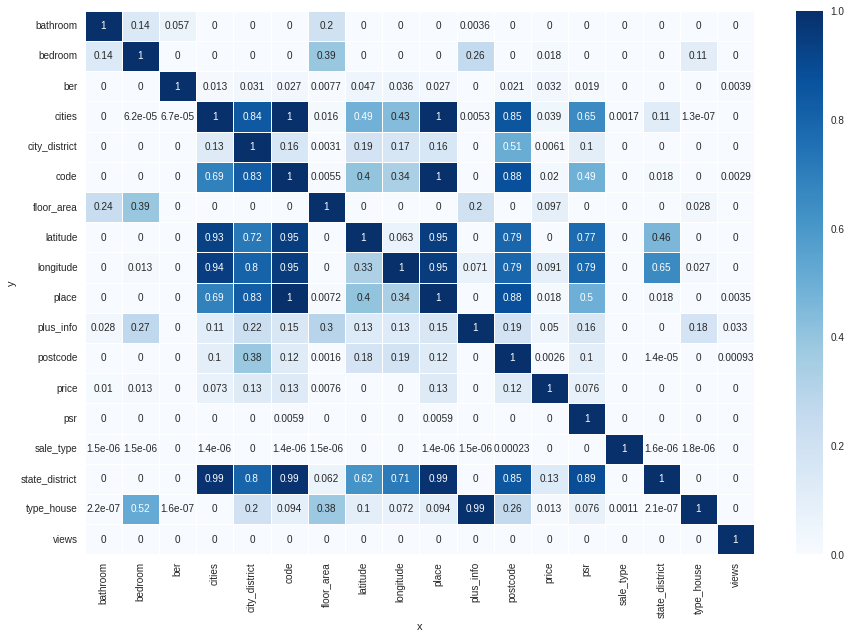

In [82]:
fig, axs = plt.subplots(figsize=(15, 10))
                               
matrix_df = pps.matrix(sale_out[variables])[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);

The PPS matrix shows a slow predictive power to predict the `price` with the other variables. This is a bit disappointing. However, let's be possitive and focus in learning what we can from the results.

- `city_district`, `code`, `place`, and `postcode` have some predictive power to the `price`. If we pay attention we can realize that all of them are **location** variables, which makes sense. Moreover, `code` and `place` are exactly the same but with different characters as place was extracted from `code` just exchanging the Eircode for the corresponding city or town.
- `cities` has some predictive power but is the same that `place` without differenciating Dublin postal districts.
- `psr` has some predictive power and it also makes sense because the psr identify the seller. It is normal to think that a particular seller will tend to offer houses in the same area or city or in close cities instead of the same number of houses in each city. So I think we could undestand the `psr` as something similar to another location variable.

There are a strong predictive power between other variables, so let's dig a little deeper on that:
- The most striking pattern is the predictive power of location variables from each others. This is normal as they are location variables. This could be a little tricky as they can proxy to each other.
- `floor_area` has a good predictive power to `bedroom` and `bathroom` which is normal as it makes sense to think that the more square meters the more rooms in the house. This also occurs in the opposite direction. A similar relationsgip occurs between `bedroom` and `bathroom`.
- The row of the `type_house` variable show us some interesting relationships. We can see that `plus_info` has an almos perfect predictive power to `type_house`. We can quickly understand why aggregating by both variables as we have done below. Normally when an element is usually in  houses it is not in apartments and viceversa. Also `bedroom` and `floor_area` have quite predictive power to `type_house` which makes sense as well because there is a relationship between them, houses usually have more square meters than apartments and there is a strong correlation between `bedroom` and `floor_area`. Finally we can see some predictive power of `city_district` and `postcode` to `type_house` and it could be because in some districts abound more houses than apartments.

In [93]:
# To understand the PPS of `plus_info` to `type_house`
sale_out.groupby(['plus_info', 'type_house'])[['daft_id']].count()

daft_id
plus_info      type_house         
Apartment      apartment      1080
Bungalow       house            18
Detached       apartment         2
               house          2519
Duplex         apartment        17
               house             4
End of Terrace apartment         1
               house           462
House          house             2
Semi-D         house          1558
Terrace        apartment         5
               house          1101
Townhouse      apartment         1
               house           103

## Wrapper Methods

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import (RFE, 
                                       SequentialFeatureSelector)
from sklearn.model_selection import train_test_split

In [64]:
num_features = ['price',
    #'sale_type', 
             'floor_area', 
             'psr',
#             'ber', 
             'views', 
 #            'type_house',
             'latitude', 
             'longitude', 
             'bedroom',
             'bathroom', 
  #           'plus_info', 
   #          'postcode', 
    #         'state_district', 
     #        'city_district',
      #       'place', 
       #      'code', 
        #     'cities', 
             #'m2_price'
            ]


sale_outna = sale_out.dropna().copy()
sale_outna = sale_outna[num_features].copy()

y = sale_outna['price'].copy()
#variables.remove('price')
X = sale_outna.drop(columns='price').copy()
#X = sale_outna1hot.drop(columns='price').copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4060, 7), (1015, 7), (4060,), (1015,))

### Recursive Feature Elimination

Problemas con los nan

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [66]:
scores_rfe = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns, '\n')
for i in range(1, X_train_num.shape[1] + 1): # i = 1,..., 1
    
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    rfe = RFE(estimator=lr, 
              n_features_to_select=i, 
              step=1) # i = 1feature, 2features...
    
    rfe.fit(X_train, y_train) # rfe con i features, nos devuelve las i mejores features
    # rfe.fit() selecciona las variables, pero no ajusta el modelo
    
    #print(rfe.support_)
    #print(rfe.ranking_)
    print(X_train.columns[rfe.support_].values, '\n')
    
    lr.fit(X_train.loc[:, rfe.support_], y_train) #rfe.support_ para seleccionar las features-columnas
    # estamos entrenando el modelo con las features q nos proporciona el objeto RFE
    scores_rfe.append(lr.score(X_test.loc[:, rfe.support_], y_test)) 
    # predecimos sobre el dataset de test con las mismas features que hemos entrenado
    
scores_rfe

NameError: name 'X_train_num' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1] + 1), scores_rfe) # x=1a13, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Forward Feature Selection

In [ ]:
scores_sfs_forward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    sfs = SequentialFeatureSelector(estimator=lr, 
                                    n_features_to_select=i, 
                                    direction='forward') 
    sfs.fit(X_train, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train.columns[sfs.support_].values, '\n')
    
    lr.fit(X_train.loc[:, sfs.support_], y_train)
    
    scores_sfs_forward.append(lr.score(X_test.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_forward

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_sfs_forward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Backward Feature Elimination

In [ ]:
scores_sfs_backward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train_num.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    sfs = SequentialFeatureSelector(estimator=dt,  #lr, 
                                    n_features_to_select=i, 
                                    direction='backward',
                                   ) 
    sfs.fit(X_train, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train.columns[sfs.support_].values, '\n')
    
    #lr.fit(X_train_num.loc[:, sfs.support_], y_train)
    dt.fit(X_train.loc[:, sfs.support_], y_train)
    
    #scores_sfs_backward.append(lr.score(X_test_num.loc[:, sfs.support_], 
     #                          y_test)) 
    scores_sfs_backward.append(dt.score(X_test.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_backward

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_sfs_backward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_rfe[:-1], label='RFE', alpha=.3) # le quitamos la ultima muestra
ax.scatter(range(1, X_train.shape[1]), scores_sfs_forward, label='SFS forward', alpha=.3)
ax.scatter(range(1, X_train.shape[1]), scores_sfs_backward, label='SFS backward', alpha=.3)

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
ax.legend()
plt.tight_layout()

## ANOVA

Let's study first the variables `place` and `price`.

- `place`: Categorical variable with more than three groups (138 groups) -> One-way ANOVA
- `price`: Numerical variaable

The hipothess will be:

* Null Hypothesis, H0: There is no significant difference between the mean `price` among different groups of `place`.
* Alternate Hypothesis, H1: There is a significant difference between the mean `price` among different groups of `place`.

In [ ]:
sale_data_out.isna().sum()

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
sale_data_out[['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']].isna().sum()

In [ ]:
cat_features = ['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']

def split_data_cat(data, cat_features, target='price'):

    y = data[target].copy()
    X = data[cat_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data_cat(data=sale_data_out, 
                      cat_features=['type_house',
                                    'postcode',
                                    'state_district',
                                    'city_district',
                                    'county',
                                    'road',
                                    'place',
                                    'code'], 
                      target='price')

In [ ]:
X_train.columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X_train.type_house)
le.classes_

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cols = ['type_house',
        'postcode',
        'state_district',
        'city_district',
        'county',
        'road',
        'place',
        'code']


for column in cols:
    X_train[column] = le.fit_transform(X_train[column])

In [ ]:
X_train[cols].columns

In [ ]:
X_train[cols].head()

In [ ]:
f_classif(X_train[['type_house']], y_train)

In [ ]:
for feature in cols:
    f_value, p_value = f_classif(X_train[[feature]], y_train)
    print(f'{feature}: f_value = {round(f_value[0], 4)}, p_value = {round(p_value[0], 4)}')

In [ ]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

# Clustering the Data